In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
transform = transforms.Compose([ # Combines multiple image transformations into a single pipeline.
    transforms.ToTensor(),  # Convert Images into PyTorch tensors
                            # PIL Image or numpy array (uint8 in [0,255]) to PyTorch Tensor (float32 in [0.0, 1.0])
                            # Changes shape from (H,W) to (C,H,W). For MNIST C = 1
    transforms.Normalize((0.5,),(0.5,))  # Normalize Pixel values to [-1,1]
])

train_dataset = datasets.MNIST(
    root='./data',   # Directory to store downloaded data
    train=True,   # Load training set (60,000 images)
    download=True,   # Download if needed
    transform=transform  # Apply the defined transform
)

test_dataset = datasets.MNIST(
    root = './data',
    train = False,   # Load test set (10,000 images)
    download = True,
    transform = transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,   # Process 64 images at once
    shuffle=True   # Shuffle data for better training
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False    # No need to shuffle test data
)

100%|██████████| 9.91M/9.91M [00:11<00:00, 866kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 296kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


In [6]:
class Net(nn.Module): # Inherits from nn.Module, the base class for all PyTorch neural networks
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # first (dense) layer => 784 pixels -> 128 neurons 
        self.fc2 = nn.Linear(128, 64) # 128 neurons from first layer -> 64 output neurons
        self.fc3 = nn.Linear(64, 10)  # Outputs 10 neurons (0-9) 
        
    def forward(self, x): # forward pass of the network
        x = x.view(-1, 28 * 28) # flattens the input image into a 784-length vector (-1 automatically adjusts the batch size)
        x = torch.relu(self.fc1(x)) # ReLU activation after fc1
        x = torch.relu(self.fc2(x)) # ReLU activation after fc2
        x = self.fc3(x) # No activation function here (It is handled by loss function (CrossEntropyLoss automatically apply softmax))
        return x
    
model = Net().to(device)

In [7]:
criterion = nn.CrossEntropyLoss() # Ideal for multiclass classification 
                                  # LogSoftMax - Converts raw output scores into probabilities
                                  # Negative Log Likelihood Loss - Compares predicted probabilities with true label
optimizer = optim.Adam(model.parameters(), lr=0.001) # Updates the model’s weights to minimize the loss during training.

In [8]:
num_epochs = 5 # Number of complete passes through entire dataset

for epoch in range(num_epochs):
    model.train() # activates layers that behave differently during training vs evaluation (Dropout, BatchNorm) - no need here but good practice
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Transfers the batch to the same device as the model
        optimizer.zero_grad() # Resets gradient from previous batch (PyTorch accumulates gradient by default)
        outputs= model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagation
        optimizer.step() 
        running_loss += loss.item() # Converts the tensor loss value to a regular Python float
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.3805
Epoch 2, Loss: 0.1808
Epoch 3, Loss: 0.1332
Epoch 4, Loss: 0.1084
Epoch 5, Loss: 0.0919


In [ ]:
model.eval() # Deactivates layers like Dropout and BatchNorm that behave differently
# Initialize Counters
correct = 0
total = 0
with torch.no_grad(): # Skips gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Value is ignored, only index of the max logit is taken
        total += labels.size(0) # number of samples in the batch
        correct += (predicted == labels).sum().item() # Gets the scalar integer of the sum of correct predictions

accuracy = correct / total # Computing total accuracy
print(f"\nAccuracy on the test set: {100 * accuracy:.2f}%")



Accuracy on the test set: 96.99%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np

In [14]:
model.eval()

all_preds = []
all_labels = []
misclassified_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Collect misclassified examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append((images[i].cpu(), predicted[i].item(), labels[i].item()))

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = np.mean(all_preds == all_labels)

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

cm = confusion_matrix(all_labels, all_preds)

print(f"\nAccuracy: {100 * accuracy:.2f}%")
print(f"Precision (macro avg): {100 * precision:.2f}%")
print(f"Recall (macro avg): {100 * recall:.2f}%")


Accuracy: 96.99%
Precision (macro avg): 96.99%
Recall (macro avg): 96.95%


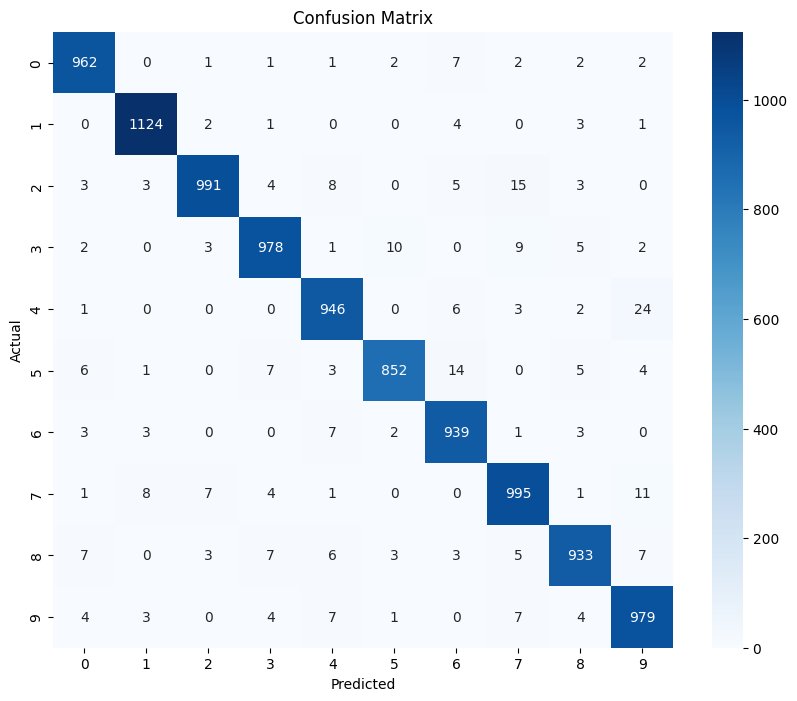

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

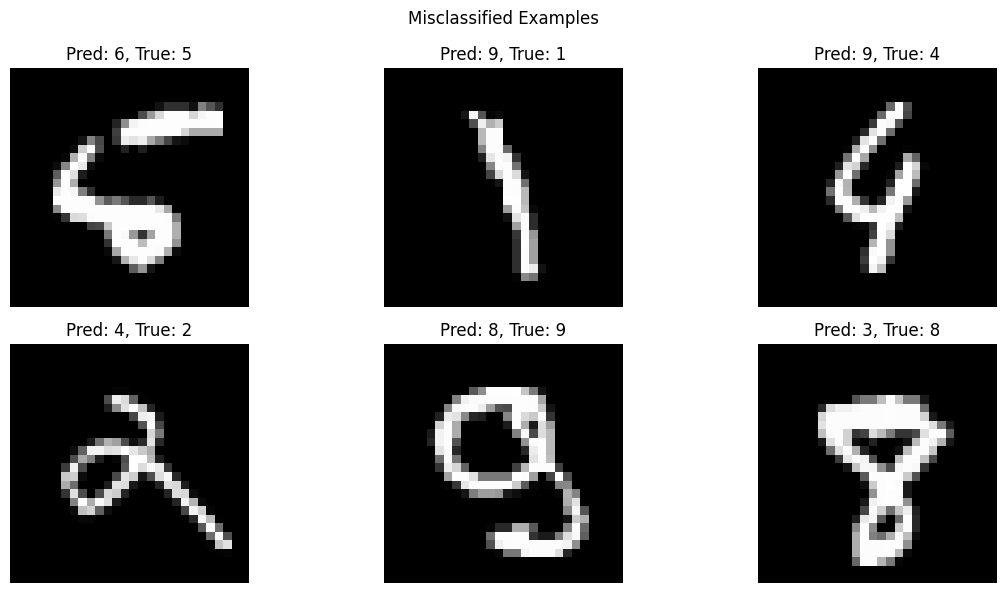

In [16]:
def imshow(img):
    img = img.squeeze()  # Remove channel dimension if exists
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Show first 6 misclassified examples
plt.figure(figsize=(12, 6))
for idx, (img, pred, true) in enumerate(misclassified_images[:6]):
    plt.subplot(2, 3, idx + 1)
    imshow(img)
    plt.title(f"Pred: {pred}, True: {true}")
plt.suptitle("Misclassified Examples")
plt.tight_layout()
plt.show()